# Обучить детектор объектов с помощью TensorFlow Object Detection API Библиотеки: [Python, Tensorflow]



### Подключение инфраструктуры

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/data/gb-cv-hw5'

In [4]:
import sys
import os
sys.path.append(ROOT_PATH)

In [5]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

#### Загрузка и подготовка библиотеки keras-retinanet

In [6]:
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [8]:
KEARS_RETINANET_PATH = ROOT_PATH + '/keras-retinanet'
SETUP_PATH = KEARS_RETINANET_PATH + '/setup.py'

!git -C '$ROOT_PATH' clone https://github.com/fizyr/keras-retinanet.git
!cd '$KEARS_RETINANET_PATH' \
        && git reset --hard abe89380835bc06dff3b97e69fa2b19dd7fd97a8 \
        && pip install . \
        && python '$SETUP_PATH' build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (4201/4201), done.
HEAD is now at abe8938 Merge pull request #1326 from fizyr/import_imagenet_weights_effnet
Processing /content/drive/My Drive/Colab Notebooks/data/gb-cv-hw5/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=168948 sha256=e40496fa151c90cd01f43b2e19acd35a1472362437e5a84364272bf4d470b875
 

#### Загрузка предобученной модели

In [9]:
MODEL_PATH = ROOT_PATH + '/resnet50_coco_best_v2.1.0.h5'
!wget "https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5" -o '$MODEL_PATH'

#### Обучение модели для детектирования объектов

In [10]:
TRAIN_PATH = KEARS_RETINANET_PATH + '/keras_retinanet/bin/train.py'
SNAPSHOT_PATH = KEARS_RETINANET_PATH + '/snapshots/'
ANNOTATIONS_PATH = ROOT_PATH + '/img/annotations.csv'
CLASSES_PATH = ROOT_PATH + '/img/classes.csv'

!python '$TRAIN_PATH' \
    --random-transform \
    --weights '$MODEL_PATH'\
    --steps 100 \
    --epochs 20 \
    --snapshot-path '$SNAPSHOT_PATH' \
    csv '$ANNOTATIONS_PATH' '$CLASSES_PATH'


Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/tensorflow-1.15.2/python3.7/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/tensorflow-1.15.2/python3.7/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2021-10-19 19:08:37.249049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-19 19:08:37.309834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 19:08:37.310711: I tensorflow/core/common_runtime/gp

### Конвертация обученной модели для инференса

In [11]:
CONVERT_PATH = KEARS_RETINANET_PATH + '/keras_retinanet/bin/convert_model.py'
MODEL_SNAPSHOT_PATH = SNAPSHOT_PATH + '/resnet50_csv_20.h5'
INFERENCE_MODEL_PATH = SNAPSHOT_PATH + '/inference_model.h5'

!python '$CONVERT_PATH' '$MODEL_SNAPSHOT_PATH' '$INFERENCE_MODEL_PATH'

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2021-10-19 19:37:57.048996: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-19 19:37:57.064351: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-19 19:37:57.064405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ba22b063ebae
2021-10-19 19:37:57.064433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ba22b063ebae
2021-10-19 19:37:57.064506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2021-10-19 19:37:57.064557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2021-10-19 19:37:57.064581: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc

### Загрузка необходимых библиотек

In [12]:
import time
import imageio
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from keras_retinanet.models import load_model
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

### Загрузка модели для инференса

In [14]:
model = load_model(INFERENCE_MODEL_PATH, backbone_name='resnet50')

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Загрузка словаря с метками классов

In [15]:
labels_to_names = {}
with open(CLASSES_PATH) as f:
    for line in f:
        cls_name, cls_id = line.split(',')
        labels_to_names[int(cls_id.strip())] = cls_name.strip()
print(labels_to_names)

{0: 'glasses'}


### Функция применения модели для детектирования объектов

In [16]:
def detect_objects(image):    
    image_processed = preprocess_image(image[:,:,::-1].copy())
    image_processed, scale = resize_image(image_processed)

    start = time.time()
    boxes, scores, labels = model.predict(image_processed[None, ...])
    print("Processing time: ", time.time() - start)
    boxes /= scale
    return boxes[0], scores[0], labels[0]

### Функция визуализации результатов детектирования объектов

In [17]:
def draw_predictions(image, predictions=None):
    draw = image.copy()
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(draw)

    if predictions is None:
        return
        
    boxes, scores, labels = predictions
    SCORE_THRESHOLD = 0.5
    for box, score, label in zip(boxes, scores, labels):
        if score < SCORE_THRESHOLD:
            break

        box_y = int(box[1])
        box_x = int(box[0])
        box_h = int(box[3]-box[1])
        box_w = int(box[2]-box[0])
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        if 0:
            color = [x/255 for x in label_color(label)]
        else:
            color =  [(0, 1, 0), (1, 1, 0), (1, 0, 1), (1, 0, 0)][label]

        label_size = 20
        plt_scale = float(fig.get_size_inches()[1]) * fig.dpi * draw.shape[0] * label_size / 12545280
        ax.add_patch(patches.Rectangle((box_x, box_y), 
                                 box_w, box_h, 
                                 linewidth=2, edgecolor=color, facecolor='none'))
        ax.add_patch(patches.Rectangle((box_x, box_y-round(26*plt_scale)), 
                                 round(plt_scale*len(caption)*14), round(26*plt_scale), 
                                 linewidth=2, edgecolor=color, facecolor=color))
        ax.text(box_x + round(3*plt_scale), box_y - round(5*plt_scale), caption, fontsize=label_size)

### Детектирование объектов на тестовом изображении


Processing time:  3.230931043624878


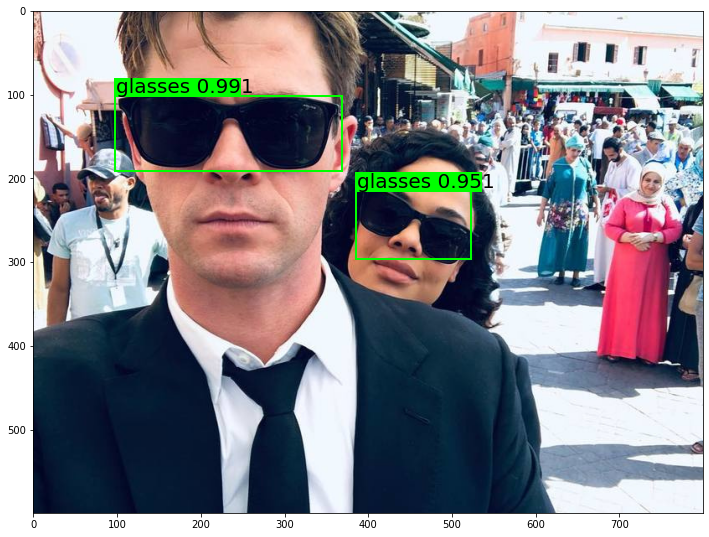

In [18]:
image = imageio.imread(ROOT_PATH + '/img/test1.jpg')
predictions = detect_objects(image)
draw_predictions(image, predictions)

Processing time:  0.34374499320983887


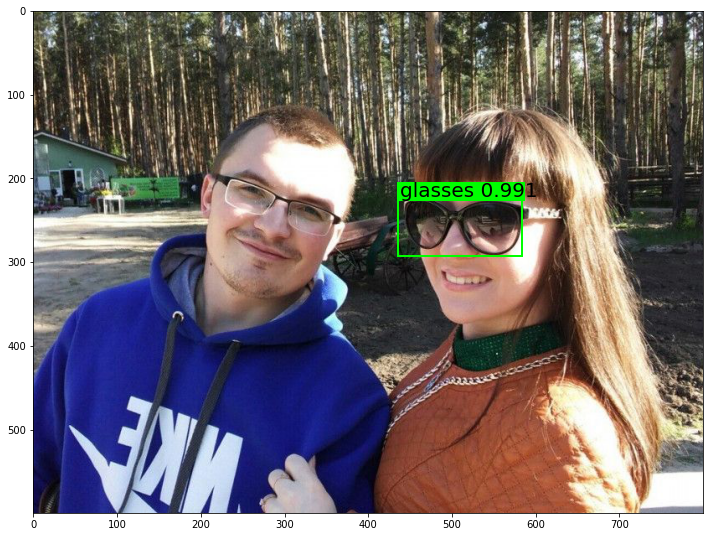

In [19]:
image = imageio.imread(ROOT_PATH + '/img/test2.jpg')
predictions = detect_objects(image)
draw_predictions(image, predictions)

Processing time:  0.3498563766479492


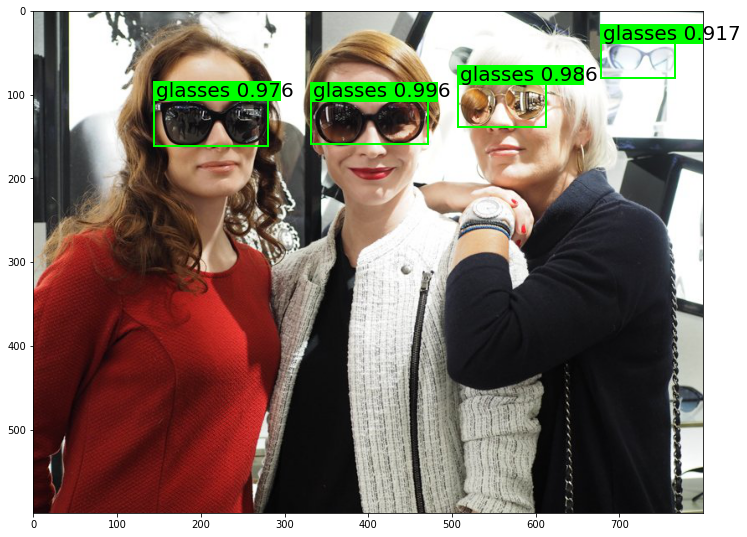

In [20]:
image = imageio.imread(ROOT_PATH + '/img/test3.jpg')
predictions = detect_objects(image)
draw_predictions(image, predictions)